<h1>Markowitz Portfolio Optimization Using Python</h1>

In this notebook, we will (1) retrieve data of stocks in our portfolio, (2) conduct basic EDA (asset correlations, returns, volatility, Sharpe), (3) optimize our portfolio using `cvxpy` and `PyPortfolioOpt`, (4) evaluate our portfolio using in-sample and out-of-sample Sharpe.

Huge credit to Valary and Yan Jean who helped a lot in revamping this tutorial workbook! (Especially making it nicer to read) <br>

The flow of the code is as follows:

1. Retrieve Stock Data (get log returns of stocks given tickers)
2. Perform Basic EDA (to understand the data - helps you identify and think about possible constraints that will be useful)
3. Example of Portfolio Optimization using cvxpy (general optimizer). Example includes one that just minimizes volatility and another that looks at also accounting for some return in the utility function.
4. Example of Portfolio Optimization using PyPortfolioOpt
5. Performing In-Sample Analysis: How to simulate investment returns. In this example, we assume fund follows a daily rebalancing strategy.
6. Perform out of sample analysis
7. Simulating Buy and Hold Investment Strategy (in my opinion, most realistic simulation for the project) - mutual funds really don't trade everyday.

# Retrieve Stock Data

```pandas-datareader``` is a Python package that allows us to retrieve financial data. In this notebook, we'll be retrieving the price and volume data of various stocks by their tickers on Yahoo Finance. For more information on reading data remotely using ```pandas-datareader```, refer to the docs: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html.

In [11]:
!pip install pandas-datareader

In [12]:
!pip install requests_cache --ignore-installed
#yahoo finance now requires new versions of pandareader to have a session cache to connect to it


  Using cached requests_cache-0.8.1-py3-none-any.whl (44 kB)
  Using cached cattrs-1.8.0-py3-none-any.whl (24 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached requests-2.26.0-py2.py3-none-any.whl (62 kB)
  Using cached url_normalize-1.4.3-py2.py3-none-any.whl (6.8 kB)
  Using cached urllib3-1.26.7-py2.py3-none-any.whl (138 kB)
  Using cached attrs-21.2.0-py2.py3-none-any.whl (53 kB)
  Using cached certifi-2021.5.30-py2.py3-none-any.whl (145 kB)
  Using cached charset_normalizer-2.0.6-py3-none-any.whl (37 kB)
  Using cached idna-3.2-py3-none-any.whl (59 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)


ERROR: conda 4.10.1 requires ruamel_yaml_conda>=0.11.14, which is not installed.


In [13]:
!pip install requests_cache

In [14]:
import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader

In [15]:
import requests_cache
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

# just add headers to your session and provide it to the reader
session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
                   'Accept': 'application/json;charset=utf-8'}


def get_data_for_multiple_stocks(tickers, start_date, end_date):
    '''
    Function that uses Pandas DataReader to download data directly from Yahoo Finance,
    computes the Log Returns series for each ticker, and returns a DataFrame 
    containing the Log Returns of all specified tickers.
    
    Parameters:
    - tickers (list): List of Stock Tickers.
    - start_date, end_date (str): Start and end dates in the format 'YYYY-MM-DD'.
    
    Returns:
    - returns_df (pd.DataFrame): A DataFrame with dates as indexes, and columns corresponding
                                 to the log returns series of each ticker.
    '''

    # initialise output dataframe
    returns_df = pd.DataFrame()
    
    for ticker in tickers:
        # retrieve stock data (includes Date, OHLC, Volume, Adjusted Close)
        s = DataReader(ticker, 'yahoo', start_date, end_date, session=session)
        # calculate log returns
        s['Log Returns'] = np.log(s['Adj Close']/s['Adj Close'].shift(1))
        # append to returns_df
        returns_df[ticker] = s['Log Returns']
        
    # skip the first row (that will be NA)
    # and fill other NA values by 0 in case there are trading halts on specific days
    returns_df = returns_df.iloc[1:].fillna(0)
        
    return returns_df

In [86]:
# Our Portfolio will consist of: Microsoft, Goldman Sachs, Disney, Mcdonalds, Johnson & Johnson, Gold
tickers =["AAPL", "MSFT", "NVDA", "CRM", "MRVL", "CSCO", "ADBE", "PYPL", "TWLO", "ZM", "NXPI", "MA", "V", "INTU", "SQ",
         "WDAY", "ADSK", "UBER", "SNAP", "FFIV", "HUBS", "ON", "MCHP", "NFLX", "G"]
returns_df = get_data_for_multiple_stocks(tickers, start_date = "2019-01-01", end_date = "2020-12-31")

In [87]:
returns_df.head()

,AAPL,MSFT,NVDA,CRM,MRVL,CSCO,ADBE,PYPL,TWLO,ZM,...,WDAY,ADSK,UBER,SNAP,FFIV,HUBS,ON,MCHP,NFLX,G
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.001141,-0.004440,0.020170,-0.010421,0.018967,-0.008808,-0.007409,0.019548,-0.026438,0.0,...,0.000376,0.002718,0.0,0.049568,-0.005260,-0.003586,0.016221,-0.007957,0.000000,-0.007438
2019-01-03,-0.104924,-0.037482,-0.062319,-0.038734,-0.045251,-0.037046,-0.040299,-0.043620,-0.068032,0.0,...,-0.036465,-0.056712,0.0,-0.019181,-0.043558,-0.052857,-0.069717,-0.073106,0.013139,-0.013529
2019-01-04,0.041803,0.045460,0.062099,0.056357,0.029368,0.044060,0.047487,0.049666,0.086037,0.0,...,0.058813,0.051425,0.0,0.046440,0.034897,0.064602,0.052889,0.039760,0.092793,0.025403
2019-01-07,-0.002228,0.001275,0.051587,0.030411,0.022527,0.006734,0.013481,0.007621,0.090937,0.0,...,0.000918,0.034026,0.0,0.042770,0.024908,0.050157,0.029853,0.028851,0.058002,0.007716
2019-01-08,0.018884,0.007224,-0.025210,0.024312,0.004805,0.008067,0.014807,0.020157,0.006373,0.0,...,0.020881,0.008627,0.0,0.030137,0.006086,0.026360,-0.027432,0.026809,0.015513,0.017057


In [88]:
simple_returns = np.exp(returns_df) -1

In [89]:
simple_returns

,AAPL,MSFT,NVDA,CRM,MRVL,CSCO,ADBE,PYPL,TWLO,ZM,...,WDAY,ADSK,UBER,SNAP,FFIV,HUBS,ON,MCHP,NFLX,G
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.001141,-0.004430,0.020375,-0.010367,0.019148,-0.008770,-0.007382,0.019741,-0.026092,0.000000,...,0.000376,0.002721,0.000000,0.050817,-0.005246,-0.003579,0.016354,-0.007925,0.000000,-0.007410
2019-01-03,-0.099607,-0.036788,-0.060417,-0.037993,-0.044242,-0.036368,-0.039498,-0.042682,-0.065770,0.000000,...,-0.035808,-0.055133,0.000000,-0.018998,-0.042623,-0.051485,-0.067342,-0.070498,0.013226,-0.013438
2019-01-04,0.042689,0.046509,0.064068,0.057976,0.029803,0.045045,0.048632,0.050920,0.089846,0.000000,...,0.060577,0.052770,0.000000,0.047535,0.035513,0.066734,0.054313,0.040561,0.097234,0.025728
2019-01-07,-0.002226,0.001275,0.052941,0.030878,0.022783,0.006757,0.013573,0.007650,0.095200,0.000000,...,0.000918,0.034612,0.000000,0.043698,0.025221,0.051436,0.030303,0.029271,0.059717,0.007746
2019-01-08,0.019063,0.007251,-0.024895,0.024610,0.004817,0.008100,0.014918,0.020361,0.006393,0.000000,...,0.021101,0.008665,0.000000,0.030596,0.006104,0.026711,-0.027059,0.027172,0.015634,0.017204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.007712,0.007827,-0.001191,-0.007255,0.013790,0.003605,0.005937,-0.003341,-0.001101,-0.022689,...,0.000000,0.004031,-0.015453,-0.030731,-0.001422,0.009345,0.005975,0.005662,-0.000991,-0.000239
2020-12-28,0.035766,0.009921,-0.007215,-0.005049,-0.001488,0.008532,-0.001820,-0.012194,-0.019896,-0.063385,...,-0.027496,-0.005773,-0.017209,-0.037687,0.004726,-0.041614,-0.001250,-0.003802,0.010020,-0.004790
2020-12-29,-0.013315,-0.003601,0.003353,-0.009704,-0.015964,-0.006233,0.006333,-0.019938,-0.014508,0.006716,...,-0.017361,-0.005139,0.005773,0.061542,-0.007651,-0.010138,-0.009077,-0.008000,0.022634,-0.010830


# Basic EDA

We will visualize the asset correlation, returns series, annualized volatility, and annualized Sharpe Ratio for each stock. <br>
Note that we will use **252 trading days a year** for our calculations, which is the convention adopted for US portfolios. 

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
round(returns_df.corr(), 2)

,AAPL,MSFT,NVDA,CRM,MRVL,CSCO,ADBE,PYPL,TWLO,ZM,...,WDAY,ADSK,UBER,SNAP,FFIV,HUBS,ON,MCHP,NFLX,G
AAPL,1.00,0.80,0.72,0.60,0.60,0.63,0.71,0.67,0.38,0.12,...,0.51,0.64,0.34,0.34,0.48,0.54,0.54,0.66,0.51,0.54
MSFT,0.80,1.00,0.77,0.73,0.64,0.68,0.85,0.78,0.47,0.15,...,0.63,0.73,0.40,0.40,0.49,0.63,0.55,0.68,0.56,0.61
NVDA,0.72,0.77,1.00,0.60,0.71,0.60,0.71,0.68,0.45,0.17,...,0.55,0.64,0.42,0.42,0.47,0.56,0.61,0.70,0.53,0.51
CRM,0.60,0.73,0.60,1.00,0.50,0.50,0.76,0.65,0.55,0.20,...,0.70,0.62,0.43,0.36,0.43,0.62,0.45,0.55,0.54,0.50
MRVL,0.60,0.64,0.71,0.50,1.00,0.58,0.58,0.59,0.37,0.11,...,0.49,0.59,0.45,0.40,0.48,0.50,0.64,0.70,0.40,0.53
CSCO,0.63,0.68,0.60,0.50,0.58,1.00,0.60,0.55,0.33,-0.05,...,0.44,0.58,0.38,0.31,0.58,0.42,0.50,0.63,0.35,0.50
ADBE,0.71,0.85,0.71,0.76,0.58,0.60,1.00,0.76,0.53,0.25,...,0.70,0.76,0.42,0.43,0.45,0.66,0.51,0.63,0.62,0.57
PYPL,0.67,0.78,0.68,0.65,0.59,0.55,0.76,1.00,0.58,0.18,...,0.61,0.65,0.42,0.45,0.41,0.67,0.49,0.59,0.46,0.55
TWLO,0.38,0.47,0.45,0.55,0.37,0.33,0.53,0.58,1.00,0.33,...,0.59,0.47,0.43,0.34,0.28,0.59,0.33,0.36,0.38,0.36
ZM,0.12,0.15,0.17,0.20,0.11,-0.05,0.25,0.18,0.33,1.00,...,0.21,0.18,0.07,0.16,-0.01,0.22,-0.05,0.05,0.27,-0.03


## Asset Correlation

In [92]:
#may need to upgrade seaborn version
!pip install seaborn --upgrade
import seaborn as sns

Requirement already up-to-date: seaborn in c:\users\dreambuilds\anaconda3\lib\site-packages (0.11.2)


Text(0.5, 1.0, 'Asset Correlations')

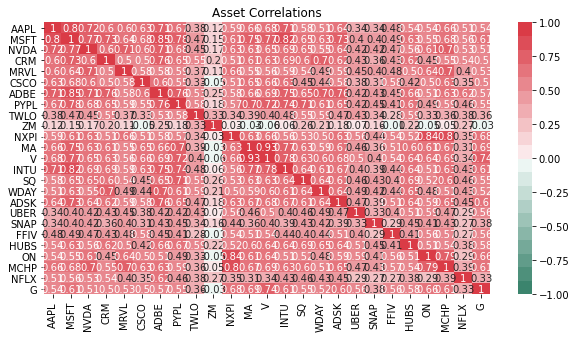

In [93]:
plt.figure(figsize=(10, 5))
sns.heatmap(round(returns_df.corr(), 2), cmap=sns.diverging_palette(160, 10, n = 20), annot=True, vmin=-1, vmax=1)
plt.title("Asset Correlations")

Here, we observe that gold (IAU) has a negative correlation with the stocks. We select stocks from different sectors to reap the benefits from diversification. If we use stocks from the same sector with very high correlation (e.g. 0.9), there will barely be any diversification benefits and we may run into issues in subsequent optimization.

## Cumulative Returns

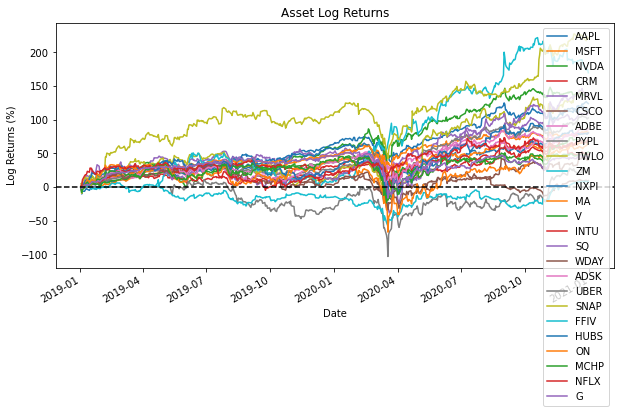

In [94]:
# convert returns to % and plot the returns series for all stocks
returns_df.expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (10, 5))
plt.title("Asset Log Returns")
plt.ylabel("Log Returns (%)")
plt.axhline(y=0, color='black', linestyle='--')

## Annualized Volatility

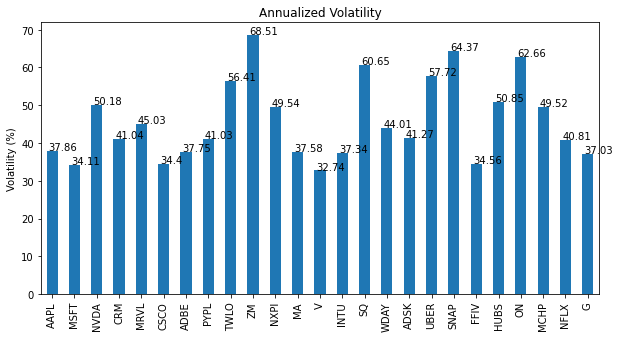

In [95]:
# calculate annualized volatility (standard deviation * sqrt(252)), expressed in %
ax = round(returns_df.std() * 252 ** 0.5 * 100, 2).plot(figsize = (10, 5), kind = "bar")
plt.title("Annualized Volatility")
plt.ylabel("Volatility (%)")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height() + 0.2))

## Annualized Sharpe Ratio

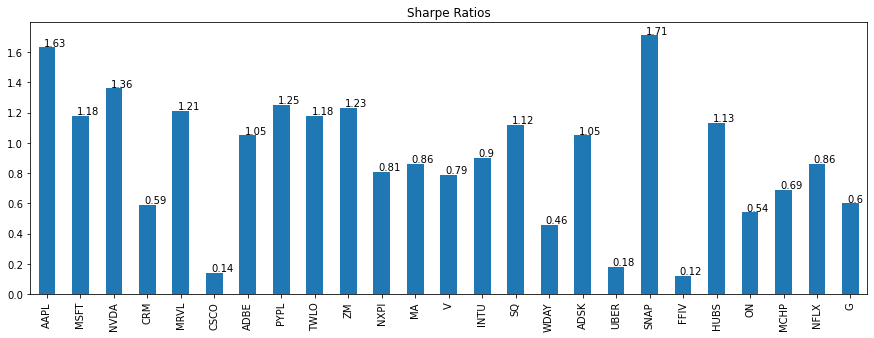

In [96]:
# calculate Sharpe Ratio, and annualize it by multiplying sqrt(252)
ax = round(returns_df.mean(axis = 0) / returns_df.std(axis = 0) * 252 ** 0.5, 2).plot(kind="bar", figsize = (15, 5))

plt.title("Sharpe Ratios")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.01))

# Portfolio Optimization

This notebook offers 2 different Python packages that you can use for portfolio optimisation, ```cvxpy``` (https://www.cvxpy.org/tutorial/intro/index.html) and ```pypfopt``` (https://pyportfolioopt.readthedocs.io/en/latest/).

To install cvxpy, you first have to install microsoft build tools from https://visualstudio.microsoft.com/downloads/
Make sure to tick the box to install the C++ build tools during installation. This is similar to Rtools to build packages in R.

We perform portfolio optimisation on the in_sample (is) period and test in the out_of_sample (oos) period.

In [97]:
!pip install cvxpy --upgrade
!pip install PyPortfolioOpt --upgrade
!pip install cvxopt

Requirement already up-to-date: cvxpy in c:\users\dreambuilds\anaconda3\lib\site-packages (1.1.15)
Requirement already up-to-date: PyPortfolioOpt in c:\users\dreambuilds\anaconda3\lib\site-packages (1.4.2)


In [98]:
!pip install cvxpy
import cvxpy as cvx
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [99]:
simple_returns

,AAPL,MSFT,NVDA,CRM,MRVL,CSCO,ADBE,PYPL,TWLO,ZM,...,WDAY,ADSK,UBER,SNAP,FFIV,HUBS,ON,MCHP,NFLX,G
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.001141,-0.004430,0.020375,-0.010367,0.019148,-0.008770,-0.007382,0.019741,-0.026092,0.000000,...,0.000376,0.002721,0.000000,0.050817,-0.005246,-0.003579,0.016354,-0.007925,0.000000,-0.007410
2019-01-03,-0.099607,-0.036788,-0.060417,-0.037993,-0.044242,-0.036368,-0.039498,-0.042682,-0.065770,0.000000,...,-0.035808,-0.055133,0.000000,-0.018998,-0.042623,-0.051485,-0.067342,-0.070498,0.013226,-0.013438
2019-01-04,0.042689,0.046509,0.064068,0.057976,0.029803,0.045045,0.048632,0.050920,0.089846,0.000000,...,0.060577,0.052770,0.000000,0.047535,0.035513,0.066734,0.054313,0.040561,0.097234,0.025728
2019-01-07,-0.002226,0.001275,0.052941,0.030878,0.022783,0.006757,0.013573,0.007650,0.095200,0.000000,...,0.000918,0.034612,0.000000,0.043698,0.025221,0.051436,0.030303,0.029271,0.059717,0.007746
2019-01-08,0.019063,0.007251,-0.024895,0.024610,0.004817,0.008100,0.014918,0.020361,0.006393,0.000000,...,0.021101,0.008665,0.000000,0.030596,0.006104,0.026711,-0.027059,0.027172,0.015634,0.017204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.007712,0.007827,-0.001191,-0.007255,0.013790,0.003605,0.005937,-0.003341,-0.001101,-0.022689,...,0.000000,0.004031,-0.015453,-0.030731,-0.001422,0.009345,0.005975,0.005662,-0.000991,-0.000239
2020-12-28,0.035766,0.009921,-0.007215,-0.005049,-0.001488,0.008532,-0.001820,-0.012194,-0.019896,-0.063385,...,-0.027496,-0.005773,-0.017209,-0.037687,0.004726,-0.041614,-0.001250,-0.003802,0.010020,-0.004790
2020-12-29,-0.013315,-0.003601,0.003353,-0.009704,-0.015964,-0.006233,0.006333,-0.019938,-0.014508,0.006716,...,-0.017361,-0.005139,0.005773,0.061542,-0.007651,-0.010138,-0.009077,-0.008000,0.022634,-0.010830


In [100]:
# define in-sample period (for optimization) and out-of-sample period (for evaluation)
in_sample = "2020-01-01"
is_returns_df = simple_returns.loc[:in_sample]
oos_returns_df = simple_returns.loc[in_sample:][1:] # one day after in_sample date

## Standard Optimization using `cvxpy`

We will set the following constraints:
1. Long Only
2. Sum of weights = 1 (Leverage of 1)
3. Risk management, single stock allocation has to be less than or equal to 50%

In [101]:
def get_optimized_portfolio(returns_df, returns_scale = .0001, max_holding = 0.5):
    """
    Function that takes in the returns series of assets, minimizes the utility function, 
    and returns the portfolio weights
    
    Parameters
    ----------
    returns_df : pd.dataframe
        Dataframe containing log asset return series in each column
    
    returns_scale : float
        The scaling factor applied to the returns
        
    max_holding : float
        The maximum weight a stock can hold.
        
    Returns
    -------
    x : np.ndarray
        A numpy ndarray containing the weights of the assets in the optimized portfolio
    """
    
    # convert returns dataframe to numpy array
    returns = returns_df.T.to_numpy()
    # m is the number of assets
    m = returns.shape[0]
  
    # covariance matrix of returns
    cov = np.cov(returns)
    
    # creating variable of weights to optimize
    x = cvx.Variable(m)
    
    # portfolio variance, in quadratic form
    portfolio_variance = cvx.quad_form(x, cov)
    print("return in simple returns")
    print(returns_df)
    log_returns_df = np.log(returns_df+1)
    print("return in log returns")
    print(log_returns_df)
    total_return_log = log_returns_df.sum().to_numpy() #this is in log space, change to simple return
    print("total return in log")
    print(total_return_log)
    print("total simple return")

    total_simple_return = np.exp(total_return_log) -1
    print(total_simple_return)
    frequency = 252 #assume daily compounding, we are going to take geometric average
    #this is the standard basic mean for optimization (to assume daily compounding)
    
    horizon_length = returns.shape[1]
    expected_mean = (1 + total_simple_return) ** (1 / horizon_length) - 1
    print("geometric return")
    print(expected_mean)
    #let's assume 
    # element wise multiplication, followed up by sum of weights
    portfolio_return = sum(cvx.multiply(expected_mean, x))
    
    # Objective Function
    # We want to minimize variance and maximize returns. We can also minimize the negative of returns.
    # Therefore, variance has to be a positive and returns have to be a negative.
    objective = cvx.Minimize(portfolio_variance - returns_scale * portfolio_return)
    
    # Constraints
    # long only, sum of weights equal to 1, no allocation to a single stock great than 50% of portfolio
    constraints = [x >= 0, sum(x) == 1, x <= max_holding]

    # use cvxpy to solve the objective
    problem = cvx.Problem(objective, constraints)
    # retrieve the weights of the optimized portfolio
    result = problem.solve()
    
    return x.value

### Only Minimize Risk, No Limit on Maximum Holdings

In [102]:
# Set max holdings to 1, no limits
example = get_optimized_portfolio(is_returns_df, returns_scale = 0, max_holding = 1)
round(pd.Series(example, index = is_returns_df.columns), 2)

return in simple returns
                AAPL      MSFT      NVDA       CRM      MRVL      CSCO  \
Date                                                                     
2019-01-02  0.001141 -0.004430  0.020375 -0.010367  0.019148 -0.008770   
2019-01-03 -0.099607 -0.036788 -0.060417 -0.037993 -0.044242 -0.036368   
2019-01-04  0.042689  0.046509  0.064068  0.057976  0.029803  0.045045   
2019-01-07 -0.002226  0.001275  0.052941  0.030878  0.022783  0.006757   
2019-01-08  0.019063  0.007251 -0.024895  0.024610  0.004817  0.008100   
...              ...       ...       ...       ...       ...       ...   
2019-12-24  0.000951 -0.000191 -0.000837 -0.002993  0.004160 -0.006653   
2019-12-26  0.019840  0.008197  0.002389  0.007718  0.014313  0.001465   
2019-12-27 -0.000380  0.001828 -0.009699  0.002857 -0.008912 -0.001672   
2019-12-30  0.005935 -0.008618 -0.019209 -0.015396 -0.010491 -0.003768   
2019-12-31  0.007307  0.000698  0.012827  0.001231  0.005680  0.007775   

            

AAPL    0.00
MSFT    0.06
NVDA    0.00
CRM     0.00
MRVL    0.00
CSCO    0.12
ADBE    0.00
PYPL   -0.00
TWLO   -0.00
ZM      0.00
NXPI    0.00
MA     -0.00
V       0.37
INTU    0.00
SQ     -0.00
WDAY    0.00
ADSK    0.00
UBER    0.01
SNAP   -0.00
FFIV    0.12
HUBS   -0.00
ON      0.00
MCHP    0.00
NFLX    0.00
G       0.32
dtype: float64

The optimization allocated the most to IAU (Gold), while allocating the least to MSFT (Microsoft). 
- A portfolio that minimizes risk only will allocate large weights to gold since it has a negative correlation with other stocks.
- If you were a fund manager, this allocation would be sub-optimal.
- In 2019 January, Microsoft P/E was relatively lower, is a stable company with steady dividends, and had many more lines of growth through for example, cloud. The optimization allocates the least to Microsoft even though Goldman Sachs has greater volatility yet low past returns.

In [103]:
#same code I just removed away all the comments

def get_optimized_portfolio(returns_df, returns_scale = .0001, max_holding = 0.5):
    """
    Function that takes in the returns series of assets, minimizes the utility function, 
    and returns the portfolio weights
    
    Parameters
    ----------
    returns_df : pd.dataframe
        Dataframe containing log asset return series in each column
    
    returns_scale : float
        The scaling factor applied to the returns
        
    max_holding : float
        The maximum weight a stock can hold.
        
    Returns
    -------
    x : np.ndarray
        A numpy ndarray containing the weights of the assets in the optimized portfolio
    """
    
    # convert returns dataframe to numpy array
    returns = returns_df.T.to_numpy()
    # m is the number of assets
    m = returns.shape[0]
  
    # covariance matrix of returns
    cov = np.cov(returns)
    
    # creating variable of weights to optimize
    x = cvx.Variable(m)
    
    # portfolio variance, in quadratic form
    portfolio_variance = cvx.quad_form(x, cov)
   
    log_returns_df = np.log(returns_df+1)
 
  
    total_return_log = log_returns_df.sum().to_numpy() #this is in log space, change to simple return
    

    total_simple_return = np.exp(total_return_log) -1
  
    frequency = 252 #assume daily compounding, we are going to take geometric average
    #this is the standard basic mean for optimization (to assume daily compounding)
    
    horizon_length = returns.shape[1]
    expected_mean = (1 + total_simple_return) ** (1 / horizon_length) - 1
   
    
    #let's assume 
    # element wise multiplication, followed up by sum of weights
    portfolio_return = sum(cvx.multiply(expected_mean, x))
    
    # Objective Function
    # We want to minimize variance and maximize returns. We can also minimize the negative of returns.
    # Therefore, variance has to be a positive and returns have to be a negative.
    objective = cvx.Minimize(portfolio_variance - returns_scale * portfolio_return)
    
    # Constraints
    # long only, sum of weights equal to 1, no allocation to a single stock great than 50% of portfolio
    constraints = [x >= 0, sum(x) == 1, x <= max_holding]

    # use cvxpy to solve the objective
    problem = cvx.Problem(objective, constraints)
    # retrieve the weights of the optimized portfolio
    result = problem.solve()
    
    return x.value

### Portfolio 1: Only Minimize Risk, Limit Maximum Holdings to 0.5

In [104]:
optimal_weights_portfolio_1 = get_optimized_portfolio(is_returns_df, returns_scale = 0, max_holding=0.5)
round(pd.Series(optimal_weights_portfolio_1, index = is_returns_df.columns), 2)

AAPL    0.00
MSFT    0.06
NVDA    0.00
CRM     0.00
MRVL    0.00
CSCO    0.12
ADBE    0.00
PYPL   -0.00
TWLO   -0.00
ZM      0.00
NXPI    0.00
MA     -0.00
V       0.37
INTU    0.00
SQ     -0.00
WDAY    0.00
ADSK    0.00
UBER    0.01
SNAP   -0.00
FFIV    0.12
HUBS   -0.00
ON      0.00
MCHP    0.00
NFLX    0.00
G       0.32
dtype: float64

By setting a limit on maximum holdings, we have reallocated some portfolio weight away from IAU (Gold). However, there is not much of a difference from the previous case.

### Portfolio 2: Minimize Risk but Place More Emphasis on Returns

In [105]:
optimal_weights_portfolio_2 = get_optimized_portfolio(is_returns_df, returns_scale = 0.04)
round(pd.Series(optimal_weights_portfolio_2, index = is_returns_df.columns), 2)

AAPL    0.14
MSFT    0.19
NVDA    0.00
CRM    -0.00
MRVL   -0.00
CSCO    0.00
ADBE    0.00
PYPL   -0.00
TWLO    0.00
ZM     -0.00
NXPI    0.01
MA      0.00
V       0.25
INTU   -0.00
SQ      0.00
WDAY    0.00
ADSK    0.00
UBER   -0.00
SNAP    0.01
FFIV    0.00
HUBS   -0.00
ON      0.00
MCHP   -0.00
NFLX    0.00
G       0.40
dtype: float64

Here, we observe that having an objective function that considers both risk and return will lead to a more balanced distribution of weights across individual assets. At your own time, feel free to explore different objective functions, and observe how the optimal weights (and subsequently, evaluation metrics like Sharpe ratio) will change with different objective functions.

## Optimization using `PyPfOpt`

PyPortfolioOpt is a library that implements portfolio optimization methods. <br>
You can refer to https://pyportfolioopt.readthedocs.io/en/latest/ for detailed documentation of the functions.

PyPortfoliOpt actually has a max_quadratic_utility function that will mirror what we tried to do in cvxpy and wraps around it such that you only provide the risk-aversion coefficient. Of course, when using external libraries you should try to also verify if what they do matches with what you think it does. But in general, it should be safe to use it for your project too.

You should read the documentation which will have links to the github code. But in general for open source projects, I sometimes suggest in order to understand them, you should use a proper IDE which allows you to do things like "Go to Definition" whilst coding (which would then allow you to step through the code to figure out what they are doing).

PyPortfolioOpt works with Annualized Figures - so means and variance matrix must be annualized.


In [106]:
# Calculate expected returns and sample covariance using PyPortfolioOpt’s built-in methods
mu = expected_returns.mean_historical_return(is_returns_df, returns_data=True)
S = risk_models.sample_cov(is_returns_df, returns_data=True)

print('Expected Returns:')
print(mu)
print('\n')
print('Covariance Matrix:')
print(S)

Expected Returns:
AAPL    0.889578
MSFT    0.575581
NVDA    0.769430
CRM     0.187413
MRVL    0.657413
CSCO    0.138126
ADBE    0.457788
PYPL    0.286360
TWLO    0.100560
ZM      0.097419
NXPI    0.757256
MA      0.591580
V       0.433270
INTU    0.341135
SQ      0.115350
WDAY    0.029872
ADSK    0.426483
UBER   -0.284580
SNAP    1.963702
FFIV   -0.138123
HUBS    0.260638
ON      0.476681
MCHP    0.480258
NFLX    0.208884
G       0.572983
dtype: float64


Covariance Matrix:
          AAPL      MSFT      NVDA       CRM      MRVL      CSCO      ADBE  \
AAPL  0.068321  0.032225  0.062035  0.028946  0.049328  0.033733  0.031512   
MSFT  0.032225  0.039317  0.045493  0.031427  0.033341  0.026746  0.034592   
NVDA  0.062035  0.045493  0.164867  0.044045  0.082468  0.049012  0.045330   
CRM   0.028946  0.031427  0.044045  0.065755  0.032348  0.025318  0.041746   
MRVL  0.049328  0.033341  0.082468  0.032348  0.114472  0.041818  0.033280   
CSCO  0.033733  0.026746  0.049012  0.025318  0.04181

### Maximize Sharpe Ratio

In [107]:
# Optimise for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
optimal_weights_portfolio_max_sharpe = ef.max_sharpe()

# Output portfolio performance
ef.portfolio_performance(verbose=True) # return, vol, sharpe

optimal_weights_portfolio_max_sharpe = np.array(list(optimal_weights_portfolio_max_sharpe.values()))
round(pd.Series(optimal_weights_portfolio_max_sharpe, index = is_returns_df.columns), 2)

Expected annual return: 105.6%
Annual volatility: 23.6%
Sharpe Ratio: 4.40


AAPL    0.44
MSFT    0.03
NVDA    0.00
CRM     0.00
MRVL    0.00
CSCO    0.00
ADBE    0.00
PYPL    0.00
TWLO    0.00
ZM      0.00
NXPI    0.00
MA      0.00
V       0.00
INTU    0.00
SQ      0.00
WDAY    0.00
ADSK    0.00
UBER    0.00
SNAP    0.25
FFIV    0.00
HUBS    0.00
ON      0.00
MCHP    0.00
NFLX    0.00
G       0.28
dtype: float64

Notice that maximizing Sharpe assigns a lot of weight on MCD (McDonalds's), and zero weight on 3 stocks. We will evaluate whether this is optimal later on.

### Minimize Risk Given Returns Limit

Fix annual returns at a specified level (15.0%) and minimise volatility.

In [108]:
ef = EfficientFrontier(mu, S)
optimal_weights_portfolio_eff_returns = ef.efficient_return(0.15)
ef.portfolio_performance(verbose=True)

optimal_weights_portfolio_eff_returns = np.array(list(optimal_weights_portfolio_eff_returns.values()))
round(pd.Series(optimal_weights_portfolio_eff_returns, index = is_returns_df.columns), 2)

Expected annual return: 37.3%
Annual volatility: 15.7%
Sharpe Ratio: 2.24


AAPL    0.00
MSFT    0.06
NVDA    0.00
CRM     0.00
MRVL    0.00
CSCO    0.12
ADBE    0.00
PYPL    0.00
TWLO    0.00
ZM      0.00
NXPI    0.00
MA      0.00
V       0.37
INTU    0.00
SQ      0.00
WDAY    0.00
ADSK    0.00
UBER    0.01
SNAP    0.00
FFIV    0.12
HUBS    0.00
ON      0.00
MCHP    0.00
NFLX    0.00
G       0.32
dtype: float64

### Maximize Returns Given Risk Limit

Fix annual volatility at a specified level (12.0%) and maximise expected annual returns.

In [109]:
ef = EfficientFrontier(mu, S)
optimal_weights_portfolio_eff_risk = ef.efficient_risk(0.12)
ef.portfolio_performance(verbose=True) # return, vol, sharpe

optimal_weights_portfolio_eff_risk = np.array(list(optimal_weights_portfolio_eff_risk.values()))
round(pd.Series(optimal_weights_portfolio_eff_risk, index = is_returns_df.columns), 2)

ValueError: The minimum volatility is 0.134. Please use a higher target_volatility

# Portfolio Evaluation

In this section, we will evaluate the different portfolios by comparing in-sample and out-sample portfolio returns, volatility, and Sharpe ratio.

## Compute Portfolio Returns given daily log returns

For this exercise, we will assume that the original index equally weights each ticker. Let's build an index that weights stocks EQUALLY. i.e Equal weighted index.

In [ ]:
index_weights = np.zeros(len(tickers)) + 1/len(tickers)
index_weights



In [ ]:
def compute_log_portfolio_returns(log_returns, weights):
    print("1. This is for the original log returns series")
    print( log_returns)

    weighted_returns = (np.exp(log_returns) - 1) * weights
    print("2. This is after the conversion back to arithmetic return series")

    print(np.exp(log_returns) - 1)
    print("3. Let's confirm the weights")

    print(weights)
    
    print("4. Multiply arithmetic series with the weights")

    print(weighted_returns)
    
    print("5. We can now sum them up to get the weights for each day")

    portfolio_returns = np.sum(weighted_returns, axis=1)
    print(portfolio_returns)
    
    print("6. We now convert it back to log returns")
    log_returns = np.log(portfolio_returns + 1)
    print(log_returns)
    
    return log_returns

In [ ]:
#returns_df is in log returns
#this is for illustration purposes in case you ORIGINALLY worked with log returns.
#which is very common for many financial models

benchmark = compute_log_portfolio_returns(returns_df, index_weights)


In [ ]:
def compute_log_portfolio_returns(log_returns, weights):
      
    #removed print statements
    #implicitly this assumes daily rebalancing - weights are equal everyday
    weighted_returns = (np.exp(log_returns) - 1) * weights
    portfolio_returns = np.sum(weighted_returns, axis=1)
    log_returns = np.log(portfolio_returns + 1)
    
    return log_returns

## The function above is incredibly important for you to understand. Log returns is time additive but it is not cross sectional weight additive. Hence, we need to convert back to arithematic returns to do the weighting.

Super troublesome but we need to do the right thing!

In [ ]:
benchmark = compute_log_portfolio_returns(returns_df, index_weights)

portfolio_1 = compute_log_portfolio_returns(returns_df, optimal_weights_portfolio_1)
portfolio_2 = compute_log_portfolio_returns(returns_df, optimal_weights_portfolio_2)

portfolio_max_sharpe = compute_log_portfolio_returns(returns_df, optimal_weights_portfolio_max_sharpe)
portfolio_eff_returns = compute_log_portfolio_returns(returns_df, optimal_weights_portfolio_eff_returns)
portfolio_eff_risk = compute_log_portfolio_returns(returns_df, optimal_weights_portfolio_eff_risk)

In [ ]:
portfolio_2

In [ ]:
all_portfolio_returns = pd.concat(
    [benchmark, portfolio_1, portfolio_2,  \
     portfolio_max_sharpe, portfolio_eff_returns, portfolio_eff_risk], axis = 1)
all_portfolio_returns.columns = ["Benchmark", "Portfolio_1", "Portfolio_2", "Portfolio_Max_Sharpe", "Portfolio_Eff_Returns", \
                                 "Portfolio_Eff_Risk"]

is_results = all_portfolio_returns[:in_sample]
oos_results = all_portfolio_returns[in_sample:][1:] # one day after in_sample date

## In Sample Results

In [ ]:
# plot returns
is_results.expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (15, 5))
plt.title("Portfolio Returns")
plt.ylabel("Returns (%)")
plt.axhline(y=0, color='black', linestyle='--')

In [ ]:
# plot volatility
ax = round(is_results.std(axis = 0) * 252 ** 0.5, 2).plot(kind="bar", figsize = (15, 5))
plt.title("Portfolio Volatility")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.001))

**Sharpe Annualization** by multiplying it with 252/sqrt(252) only actually makes sense if numerator is in log returns. Otherwise, if it is in simple returns, you need to take geometric compounding on the numerator instead of multiplying it by 252. Although either way it will not be too far off in general short of very exceptional periods. I recommend working with log returns after you figure out the weights at the end. Markowitz's portfolio optimization should be in the arithmetic return space


The idea here is that you annualize returns by multiplying it by 252 (legitimate) as they are continuously compounded so you can just add them up and you will get the annualized returns if they were continuously compounded.

You annualize volatility with root 252. Therefore multiplying daily sharpe ratio by sqrt(252) makes sense.



In [ ]:
# plot sharpe
ax = round(is_results.mean(axis = 0) / is_results.std(axis = 0) * 252 ** 0.5, 2).plot(kind="bar", figsize = (15, 5))
plt.title("In Sample Sharpe Ratios")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.01))

- Portfolio_1 and Portfolio_2: The optimization minimized the risk of the portfolios. However, from the sharpe ratio, we can see that the sharpe ratio of Portfolio_1 is the lowest as it did not consider returns. 
- Notice that using `max_sharpe()` in PyPfOpt may not necessarily result in the highest in-sample Sharpe ratios. This is because: we did daily rebalancing whereas max_sharpe is an approximation function to a non-convex problem that maximizes for mean/std

## Out of Sample Results

In [ ]:
oos_results.expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (15, 5))
plt.title("Out of Sample Portfolio Returns")
plt.ylabel("Returns (%)")
plt.axhline(y=0, color='black', linestyle='--')

Plotting correlations during the covid-19 crisis (February 1st - April 1st), we observe that most correlations are close to 1. Gold's correlation with other stocks also became positive. Thus, all portfolios still suffered during the crisis.

In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(round(returns_df.loc["2020-02-01":"2020-04-01"].corr(), 2), cmap=sns.diverging_palette(160, 10, n = 20), annot=True, vmin=-1, vmax=1)
plt.title("Stock Correlations")

In [ ]:
ax = round(oos_results.mean(axis = 0) / oos_results.std(axis = 0) * 252 ** 0.5, 2).plot(kind="bar", figsize = (15, 5))
plt.title("Out of Sample Sharpe Ratios")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.01))

Surprisingly, the out of sample for Portfolio_1 and Portfolio_2 has good sharpe ratio (despite having the worse in-sample Sharpe). 

Although the max sharpe optimization obtained one of the highest sharpe ratio in sample, it actually resulted in an out of sample with the worst sharpe ratio lower than the benchmark. This shows that the optimization can "overfit" on the in-sample data and find a solution that is not optimal for the future.

**Actually, the above investment scenarios is not realistic - can we really assume weights of each stock are equal everyday? That would entail the portfolio having to rebalance every day - is this realistic for a mutual fund? No. Most mutual funds generally buy and hold stocks a good amount of time, or if they rebalance, they may only do it monthly or quarterly to minimize expenses.**

Having to rebalance everyday entails having to buy large amounts of securities everyday and if one trades everyday, it is not realistic to actually get the reported numbers since we never accounted for transaction costs. 

Let's see how one can make it more realistic. We assume that once weights has been optimized, we find out the number of shares the fund will hold. Let's use Portfolio 2 as the base. What is the optimal weights of the portfolio?

In [ ]:
optimal_weights_portfolio_2

Notice that one of the weights is so small that it may cause problems. Can we actually buy 1 share of that stock?

In [ ]:
sum(optimal_weights_portfolio_2) #just to verify sum is 1

The package below is one from PyPfOpt, it is very good to help us figure out how many shares to buy given a weight. Otherwise, we have to calculate manually by dividing the amount needed by the price

In [ ]:
from pypfopt.discrete_allocation import DiscreteAllocation

Well we actually need the price data first, but the original code only grabs the log_returns. Let's get price seperately.

In [ ]:

def get_price_data_for_multiple_stocks(tickers, start_date, end_date):
    '''
    Function that uses Pandas DataReader to download data directly from Yahoo Finance,
    computes the Prices series for each ticker, and returns a DataFrame 
    containing the Prices of all specified tickers.
    
    Parameters:
    - tickers (list): List of Stock Tickers.
    - start_date, end_date (str): Start and end dates in the format 'YYYY-MM-DD'.
    
    Returns:
    - prices_df (pd.DataFrame): A DataFrame with dates as indexes, and columns corresponding
                                 to the prices series of each ticker.
    '''

    # initialise output dataframe
    prices_df = pd.DataFrame()
    
    for ticker in tickers:
        # retrieve stock data (includes Date, OHLC, Volume, Adjusted Close)
        s = DataReader(ticker, 'yahoo', start_date, end_date, session=session)
       
        # append to returns_df
        prices_df[ticker] = s['Adj Close']
        
    # skip the first row (that will be NA)
    # and fill other NA values by 0 in case there are trading halts on specific days
    prices_df = prices_df.iloc[1:].fillna(0)
        
    return prices_df

In [ ]:
prices_df = get_price_data_for_multiple_stocks(tickers, start_date = "2015-01-01", end_date = "2020-09-08")

In [ ]:
in_sample = "2018-12-31"
is_prices_df = prices_df.loc[:in_sample]
oos_prices_df = prices_df.loc[in_sample:][1:] # one day after in_sample date

One way to get last row of the sample

In [110]:
is_prices_df.iloc[[-1]]  

,AAPL,MSFT,NVDA,CRM,MRVL,CSCO,ADBE,PYPL,TWLO,ZM
Date,,,,,,,,,,
2018-12-31,38.338478,98.397255,33.165493,136.970001,15.876915,39.84618,226.240005,84.089996,89.300003,0.0


Changing dataframe to series so we can work with it later

In [111]:
is_prices_df.iloc[[-1]].squeeze() #that's one way to get series of the last row

AAPL     38.338478
MSFT     98.397255
NVDA     33.165493
CRM     136.970001
MRVL     15.876915
CSCO     39.846180
ADBE    226.240005
PYPL     84.089996
TWLO     89.300003
ZM        0.000000
Name: 2018-12-31 00:00:00, dtype: float64

There is also a function in PyPortfolioOpt is very useful, it simply takes the last row of the dataframe and converts it into the series we need. Instead of doing the above

In [112]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(is_prices_df)
latest_prices

AAPL     38.338478
MSFT     98.397255
NVDA     33.165493
CRM     136.970001
MRVL     15.876915
CSCO     39.846180
ADBE    226.240005
PYPL     84.089996
TWLO     89.300003
ZM        0.000000
Name: 2018-12-31 00:00:00, dtype: float64

In [113]:
type(latest_prices)

pandas.core.series.Series

The input to the DiscreteAllocation library needs to be a dictionary. So we need to be prepared to convert our weight series data (and prices to dictionaries). First we append back the index to the series data

In [114]:
optimal_weights_dict = pd.Series(optimal_weights_portfolio_2, index = is_returns_df.columns)
optimal_weights_dict

AAPL    1.412086e-01
MSFT    1.886624e-01
NVDA    3.512194e-23
CRM    -4.594095e-23
MRVL   -4.627786e-23
CSCO    7.607175e-23
ADBE    8.227428e-23
PYPL   -6.250426e-23
TWLO    2.609983e-23
ZM     -1.611800e-23
NXPI    1.484395e-02
MA      1.413517e-23
V       2.475094e-01
INTU   -2.598565e-23
SQ      4.793918e-23
WDAY    4.247782e-23
ADSK    1.273392e-23
UBER   -5.127260e-24
SNAP    1.076507e-02
FFIV    3.282571e-23
HUBS   -3.924860e-24
ON      2.874603e-23
MCHP   -5.335230e-23
NFLX    6.249540e-24
G       3.970105e-01
dtype: float64

In [115]:
type(optimal_weights_dict)

pandas.core.series.Series

In [116]:
w = optimal_weights_dict.to_dict()

In [117]:
w

{'AAPL': 0.1412086278722876,
 'MSFT': 0.18866244116143704,
 'NVDA': 3.5121942965565156e-23,
 'CRM': -4.594094508865704e-23,
 'MRVL': -4.6277862902975096e-23,
 'CSCO': 7.607175257501428e-23,
 'ADBE': 8.22742843068563e-23,
 'PYPL': -6.250425631813545e-23,
 'TWLO': 2.609983162779776e-23,
 'ZM': -1.611800482378001e-23,
 'NXPI': 0.01484395296872278,
 'MA': 1.4135172272300117e-23,
 'V': 0.24750942052593347,
 'INTU': -2.5985652836117708e-23,
 'SQ': 4.793917965921132e-23,
 'WDAY': 4.247781924548582e-23,
 'ADSK': 1.2733918562763964e-23,
 'UBER': -5.1272600768039894e-24,
 'SNAP': 0.010765065359978303,
 'FFIV': 3.282570800644146e-23,
 'HUBS': -3.924859877540153e-24,
 'ON': 2.8746025101682794e-23,
 'MCHP': -5.335229995192192e-23,
 'NFLX': 6.249540162579291e-24,
 'G': 0.3970104921116409}

In [118]:
#if you run into an error regarding GLPK_MI not installed
#refer to https://github.com/cvxpy/cvxpy/issues/972
#you may have to run the pip command inside the conda environment to work

#very annoying dependency bug!

In [119]:
import cvxpy, cvxopt
cvxpy.installed_solvers()
#if GLPK_MI appears here, you likely solved the problem and have to restart maybe

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']

Let's allocate 20000 dollars of shares to buy stocks according to the weights. We let DiscreteAllocation solve how many shares to buy to meet the weights

In [131]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

da = DiscreteAllocation(w, latest_prices, total_portfolio_value=20000)
allocation, leftover = da.lp_portfolio()
print(allocation)
print(leftover)

{'MSFT': 16, 'DIS': 16, 'MCD': 30, 'JNJ': 19, 'IAU': 381}
31.861215591430664


### We don't actually have GS because it is too low. that's ok. That is actually correct.

In [132]:
optimal_weights_dict["GS"] *20000 / latest_prices["GS"] #nowhere near the amount of shares to be bought

3.030580289754488e-16

In [133]:
optimal_weights_dict["MSFT"] *20000 / latest_prices["MSFT"]

15.811004954125233

### Sanity Check

In [134]:
oos_portfolio = oos_prices_df

In [135]:
def get_market_value_of_stocks(price_values, no_of_shares_dict):
    market_value = 0
    price_dict = price_values.to_dict()
    for key in price_dict:
        if(key not in no_of_shares_dict):
            continue #not allocated, let's pass it.
        market_value += (price_dict[key] * no_of_shares_dict[key])
        
    return market_value
    
oos_portfolio["Market Value"] = oos_prices_df.apply(lambda x: get_market_value_of_stocks(x,allocation), axis=1)

Just a sanity check, the next trading day's close market value shouldn't be that far off from the initial amount invested the previous day... unless there was a flash crash on that day. (Literally you bought at the high)

In [136]:
oos_portfolio["Prev Market Value"] = oos_portfolio["Market Value"].shift(1)
oos_portfolio["log_returns"] = np.log(oos_portfolio["Market Value"]/oos_portfolio["Prev Market Value"])
oos_portfolio

,MSFT,GS,DIS,MCD,JNJ,IAU,Market Value,Prev Market Value,log_returns
Date,,,,,,,,,
2019-01-02,97.961319,163.395172,107.654343,165.785156,118.758553,24.600000,19892.417917,NaN,NaN
2019-01-03,94.357529,161.001663,105.046211,164.692841,116.871422,24.820000,19808.221954,19892.417917,-0.004242
2019-01-04,98.746010,166.263626,108.286606,167.875580,118.832924,24.639999,19994.454567,19808.221954,0.009358
2019-01-07,98.871956,167.184906,109.225136,169.702393,118.070641,24.700001,20074.667706,19994.454567,0.004004
2019-01-08,99.588829,166.567520,110.074753,170.060226,120.813011,24.639999,20139.711082,20074.667706,0.003235
...,...,...,...,...,...,...,...,...,...
2020-09-01,225.203552,202.861526,133.550003,208.986145,147.736786,37.599998,29142.239586,29124.393349,0.000613
2020-09-02,229.543701,207.383591,135.389999,212.464493,149.989120,37.139999,29213.007050,29142.239586,0.002425
2020-09-03,215.324188,204.934967,133.240005,210.076813,145.815979,36.799999,28670.634792,29213.007050,-0.018741


# Hold Portfolio and Track Returns
Now that we've figured out the number of shares to buy for a fund at the start of the investment period, we will simulate buying it and tracking its returns.

In [137]:
# preparing portfolio df
oos_portfolio

,MSFT,GS,DIS,MCD,JNJ,IAU,Market Value,Prev Market Value,log_returns
Date,,,,,,,,,
2019-01-02,97.961319,163.395172,107.654343,165.785156,118.758553,24.600000,19892.417917,NaN,NaN
2019-01-03,94.357529,161.001663,105.046211,164.692841,116.871422,24.820000,19808.221954,19892.417917,-0.004242
2019-01-04,98.746010,166.263626,108.286606,167.875580,118.832924,24.639999,19994.454567,19808.221954,0.009358
2019-01-07,98.871956,167.184906,109.225136,169.702393,118.070641,24.700001,20074.667706,19994.454567,0.004004
2019-01-08,99.588829,166.567520,110.074753,170.060226,120.813011,24.639999,20139.711082,20074.667706,0.003235
...,...,...,...,...,...,...,...,...,...
2020-09-01,225.203552,202.861526,133.550003,208.986145,147.736786,37.599998,29142.239586,29124.393349,0.000613
2020-09-02,229.543701,207.383591,135.389999,212.464493,149.989120,37.139999,29213.007050,29142.239586,0.002425
2020-09-03,215.324188,204.934967,133.240005,210.076813,145.815979,36.799999,28670.634792,29213.007050,-0.018741


In [138]:
portfolio_2_hold = oos_portfolio["log_returns"]
portfolio_2_hold

Date
2019-01-02         NaN
2019-01-03   -0.004242
2019-01-04    0.009358
2019-01-07    0.004004
2019-01-08    0.003235
                ...   
2020-09-01    0.000613
2020-09-02    0.002425
2020-09-03   -0.018741
2020-09-04   -0.003544
2020-09-08   -0.005496
Name: log_returns, Length: 425, dtype: float64

### Comparison to Benchmark and Daily Rebalanced Portfolio

Note that the benchmark for this example is an EQUAL weighted index. You are not to assume it is equal weighted. Indeed,for example, if you're using S&P500, what you can simply do is the benchmark returns is simply extract the log returns of ^GSPC and actually that will be your index benchmark to track. No need to rebalance since it is value weighted.

In [139]:
all_portfolio_returns = pd.concat(
    [benchmark, portfolio_2, portfolio_2_hold], axis = 1)
all_portfolio_returns.columns = ["Benchmark", "Portfolio_2", "Portfolio_2_Buy_And_Hold"]

is_results = all_portfolio_returns[:in_sample]
oos_results = all_portfolio_returns[in_sample:][1:] # one day after in_sample date

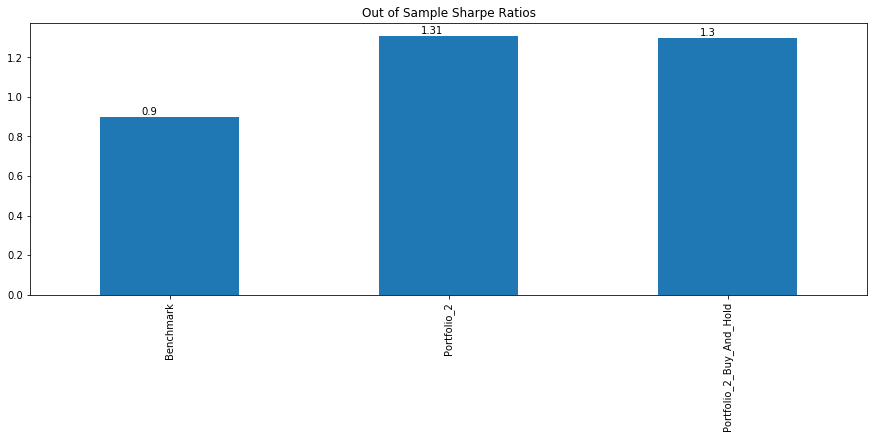

In [140]:
ax = round(oos_results.mean(axis = 0) / oos_results.std(axis = 0) * 252 ** 0.5, 2).plot(kind="bar", figsize = (15, 5))
plt.title("Out of Sample Sharpe Ratios")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.01))

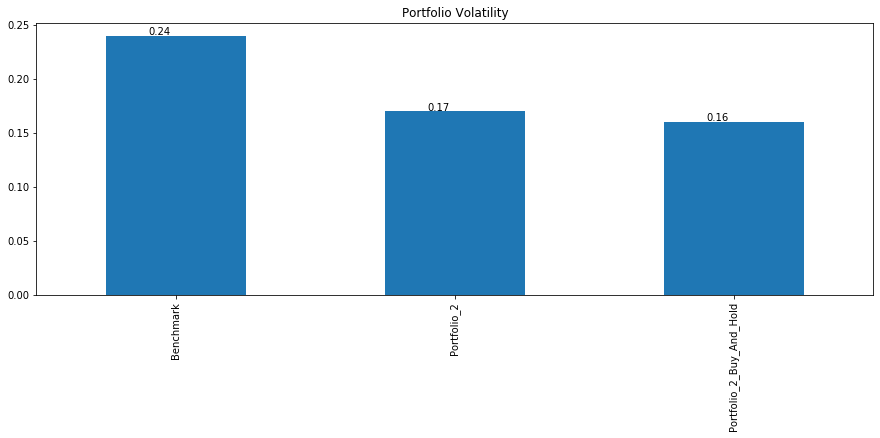

In [141]:
# plot volatility
ax = round(oos_results.std(axis = 0) * 252 ** 0.5, 2).plot(kind="bar", figsize = (15, 5))
plt.title("Portfolio Volatility")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.001))

**Buy and Hold Portfolio 2 has similar results to the daily rebalanced Portfolio 2's one but realistically, would far exceed Portfolio 2's after taking account trading costs.**

This frankly, would be far better representation of what your fund would be doing rather than rebalancing daily - if you rebalance daily to optimized weights, it is also possible you run into the problem of assuming fractional shares can be bought and sold. This is a very forceful assumption to enforce.